In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.shopify_scraper import fetch_products

sns.set()

ModuleNotFoundError: No module named 'src'

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.shopify_scraper import fetch_products

sns.set()

ModuleNotFoundError: No module named 'src'

In [3]:
import sys
import os

# Get absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.shopify_scraper import fetch_products

sns.set()

In [4]:
STORE_URL = "https://kyliecosmetics.com"

df_raw = fetch_products(STORE_URL, limit=250)
df_raw.head()
df_raw.columns

Index(['id', 'title', 'handle', 'body_html', 'published_at', 'created_at',
       'updated_at', 'vendor', 'product_type', 'tags', 'variants', 'images',
       'options'],
      dtype='object')

In [5]:
def extract_main_price(row):
    variants = row.get("variants", [])
    if not variants:
        return np.nan
    v0 = variants[0]
    try:
        return float(v0.get("price")) if v0.get("price") is not None else np.nan
    except ValueError:
        return np.nan

# Make a working copy
df = df_raw.copy()

df["main_price"] = df_raw.apply(extract_main_price, axis=1)
df["title_len"] = df["title"].astype(str).str.len()
df["desc_len"] = df["body_html"].astype(str).str.len()
df["tags_list"] = df["tags"].fillna("").apply(lambda x: [t.strip() for t in x.split(",") if t.strip()])  # tags is often a comma-separated string


AttributeError: 'list' object has no attribute 'split'

In [6]:
def extract_main_price(row):
    variants = row.get("variants", [])
    if not variants:
        return np.nan
    v0 = variants[0]
    try:
        return float(v0.get("price")) if v0.get("price") is not None else np.nan
    except ValueError:
        return np.nan

# Make a working copy
df = df_raw.copy()

df["main_price"] = df_raw.apply(extract_main_price, axis=1)
df["title_len"] = df["title"].astype(str).str.len()
df["desc_len"] = df["body_html"].astype(str).str.len()
import pandas as pd

def normalize_tags(x):
    # Case 1: already a list → clean it
    if isinstance(x, list):
        return [str(t).strip() for t in x if str(t).strip()]

    # Case 2: missing / null
    if pd.isna(x):
        return []

    # Case 3: string of comma-separated tags
    return [t.strip() for t in str(x).split(",") if t.strip()]

df["tags_list"] = df["tags"].apply(normalize_tags)

In [7]:
df[["title", "product_type", "main_price", "tags_list"]].head()
df["main_price"].describe()

count    250.000000
mean      69.865160
std       69.432788
min        0.000000
25%       25.000000
50%       38.000000
75%       89.775000
max      380.000000
Name: main_price, dtype: float64

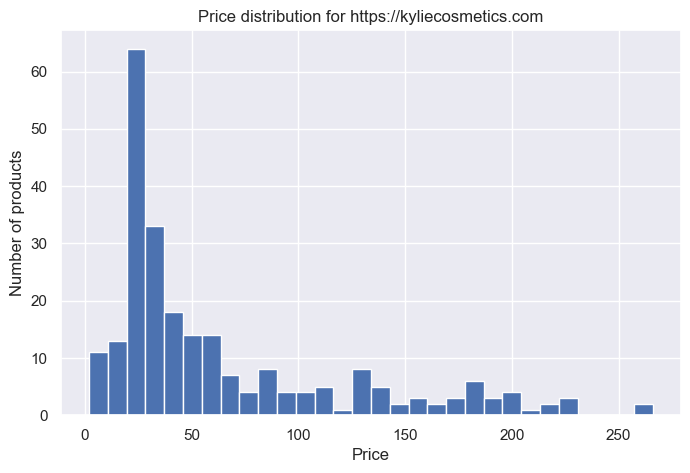

count    249.000000
mean      70.145743
std       69.430470
min        2.000000
25%       25.000000
50%       38.000000
75%       90.000000
max      380.000000
Name: main_price, dtype: float64

In [8]:
# Drop missing or insane prices
df_price = df[df["main_price"].notna() & (df["main_price"] > 0)]

# Optional: remove top 2–5% as outliers
upper = df_price["main_price"].quantile(0.98)
df_price_trim = df_price[df_price["main_price"] <= upper]

plt.figure(figsize=(8,5))
plt.hist(df_price_trim["main_price"], bins=30)
plt.title(f"Price distribution for {STORE_URL}")
plt.xlabel("Price")
plt.ylabel("Number of products")
plt.show()

df_price["main_price"].describe()

In [9]:
df_types = (
    df.assign(product_type=df["product_type"].fillna("Unspecified"))
      .groupby("product_type")["id"]
      .count()
      .sort_values(ascending=False)
      .reset_index(name="count")
)

df_types.head(10)

,product_type,count
0,Bundle,94
1,Look,29
2,Sample,21
3,Set,21
4,Brush,6
5,Face Brush,5
6,Lip Gloss,5
7,Lip Kit,5
8,Fragrance,4
9,Mascara,4


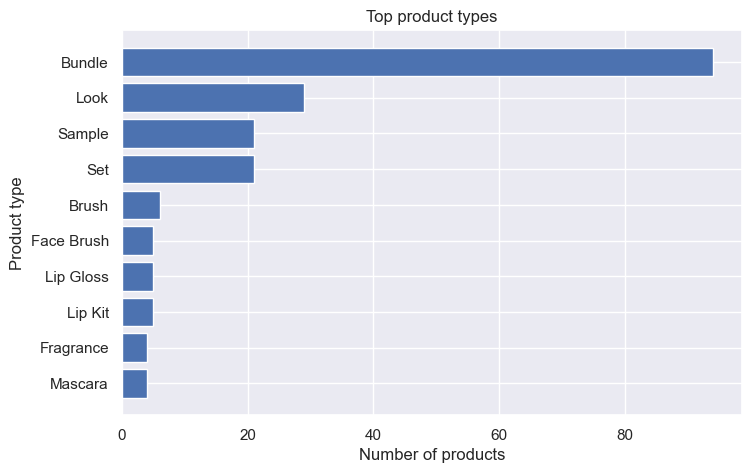

In [10]:
top_types = df_types.head(10)

plt.figure(figsize=(8,5))
plt.barh(top_types["product_type"], top_types["count"])
plt.gca().invert_yaxis()
plt.title("Top product types")
plt.xlabel("Number of products")
plt.ylabel("Product type")
plt.show()

In [11]:
from collections import Counter

all_tags = []
for tags in df["tags_list"]:
    all_tags.extend(tags)

tag_counts = Counter(all_tags)
tags_df = (
    pd.DataFrame(tag_counts.items(), columns=["tag", "count"])
    .sort_values("count", ascending=False)
    .head(20)
)

tags_df

,tag,count
150,Brand_Principles:vegan,171
149,Brand_Principles:cruelty free,169
148,Brand_Principles:clean,152
33,nosto_exclude,136
0,#hide-sale,105
284,memorial-promo-ineligible,67
219,price_range:under $30,59
197,Brand_Principles:paraben free,51
249,exclude_sale,46
201,price_range:$30-$60,41


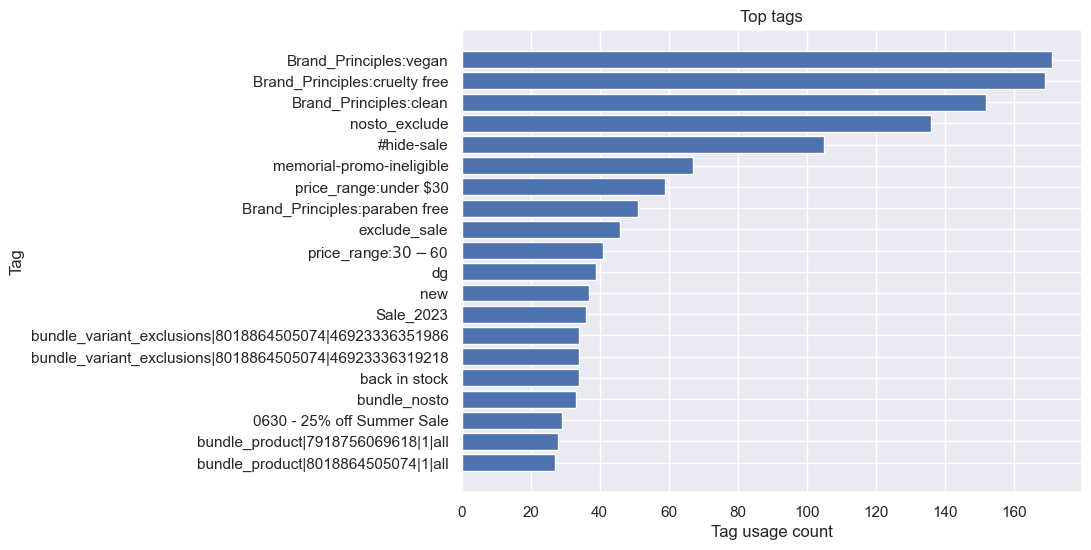

In [12]:
plt.figure(figsize=(8,6))
plt.barh(tags_df["tag"], tags_df["count"])
plt.gca().invert_yaxis()
plt.title("Top tags")
plt.xlabel("Tag usage count")
plt.ylabel("Tag")
plt.show()

In [13]:
n_products = len(df)
n_priced = df_price.shape[0]

price_desc = df_price["main_price"].describe()

print(f"Store: {STORE_URL}")
print(f"Total products found: {n_products}")
print(f"Products with valid price: {n_priced}")
print()
print("Price summary (USD):")
print(price_desc[["min", "25%", "50%", "75%", "max"]])
print()
print("Top product types:")
print(df_types.head(5).to_string(index=False))
print()
print("Top tags:")
print(tags_df.head(10).to_string(index=False))

Store: https://kyliecosmetics.com
Total products found: 250
Products with valid price: 249

Price summary (USD):
min      2.0
25%     25.0
50%     38.0
75%     90.0
max    380.0
Name: main_price, dtype: float64

Top product types:
product_type  count
      Bundle     94
        Look     29
      Sample     21
         Set     21
       Brush      6

Top tags:
                          tag  count
       Brand_Principles:vegan    171
Brand_Principles:cruelty free    169
       Brand_Principles:clean    152
                nosto_exclude    136
                   #hide-sale    105
    memorial-promo-ineligible     67
        price_range:under $30     59
Brand_Principles:paraben free     51
                 exclude_sale     46
          price_range:$30-$60     41
